Lambda School Data Science

*Unit 2, Sprint 2, Module 4*

---

# Classification Metrics

## Assignment
- [ ] If you haven't yet, [review requirements for your portfolio project](https://lambdaschool.github.io/ds/unit2), then submit your dataset.
- [ ] Plot a confusion matrix for your Tanzania Waterpumps model.
- [ ] Continue to participate in our Kaggle challenge. Every student should have made at least one submission that scores at least 70% accuracy (well above the majority class baseline).
- [ ] Submit your final predictions to our Kaggle competition. Optionally, go to **My Submissions**, and _"you may select up to 1 submission to be used to count towards your final leaderboard score."_
- [ ] Commit your notebook to your fork of the GitHub repo.
- [ ] Read [Maximizing Scarce Maintenance Resources with Data: Applying predictive modeling, precision at k, and clustering to optimize impact](http://archive.is/DelgE), by Lambda DS3 student Michael Brady. His blog post extends the Tanzania Waterpumps scenario, far beyond what's in the lecture notebook.


## Stretch Goals

### Reading

- [Attacking discrimination with smarter machine learning](https://research.google.com/bigpicture/attacking-discrimination-in-ml/), by Google Research, with  interactive visualizations. _"A threshold classifier essentially makes a yes/no decision, putting things in one category or another. We look at how these classifiers work, ways they can potentially be unfair, and how you might turn an unfair classifier into a fairer one. As an illustrative example, we focus on loan granting scenarios where a bank may grant or deny a loan based on a single, automatically computed number such as a credit score."_
- [Notebook about how to calculate expected value from a confusion matrix by treating it as a cost-benefit matrix](https://github.com/podopie/DAT18NYC/blob/master/classes/13-expected_value_cost_benefit_analysis.ipynb)
- [Visualizing Machine Learning Thresholds to Make Better Business Decisions](https://blog.insightdatascience.com/visualizing-machine-learning-thresholds-to-make-better-business-decisions-4ab07f823415)


### Doing
- [ ] Share visualizations in our Slack channel!
- [ ] RandomizedSearchCV / GridSearchCV, for model selection. (See module 3 assignment notebook)
- [ ] Stacking Ensemble. (See module 3 assignment notebook)
- [ ] More Categorical Encoding. (See module 2 assignment notebook)

In [3]:
%%capture
import sys

# If you're on Colab:
if 'google.colab' in sys.modules:
    DATA_PATH = 'https://raw.githubusercontent.com/LambdaSchool/DS-Unit-2-Kaggle-Challenge/master/data/'
    !pip install category_encoders==2.*

# If you're working locally:
else:
    DATA_PATH = '../data/'

In [4]:
DATA_PATH = 'https://raw.githubusercontent.com/LambdaSchool/DS-Unit-2-Kaggle-Challenge/master/data/'
import pandas as pd

# Merge train_features.csv & train_labels.csv
train = pd.merge(pd.read_csv(DATA_PATH+'waterpumps/train_features.csv'), 
                 pd.read_csv(DATA_PATH+'waterpumps/train_labels.csv'))

# Read test_features.csv & sample_submission.csv
test = pd.read_csv(DATA_PATH+'waterpumps/test_features.csv')
sample_submission = pd.read_csv(DATA_PATH+'waterpumps/sample_submission.csv')

In [5]:
import numpy as np
# wrangle the data to get going
def wrangle(X):
  X = X.copy()
  # set the index to train and test
  X['latitude'] = X['latitude'].replace(-2e-08, 0)
  cols_with_zeros = ['longitude', 'latitude', 'construction_year',
                       'gps_height', 'population']
  for col in cols_with_zeros:
        X[col] = X[col].replace(0, np.nan)
        X[col+'_MISSING'] = X[col].isnull()
    # drop the duplicate columns
  duplicates = ['quantity_group', 'payment_type']
  X = X.drop(columns=duplicates)

  # Drop recorded by (never varies) and id(always varies, random)
  unusable_variance =['recorded_by', 'id']
  X = X.drop(columns = unusable_variance)

  #convert date into datetime object
  X['date_recorded'] = pd.to_datetime(X['date_recorded'], infer_datetime_format=True)

  #Extract components from date_recorded then drop the original column
  X['year_recorded'] = X['date_recorded'].dt.year
  X['month_recorded'] = X['date_recorded'].dt.month
  X['day_recorded'] = X['date_recorded'].dt.day
  X = X.drop(columns = 'date_recorded')

  #Engineer the features: how many years from construction_year to date_recorded
  X['years'] = X['year_recorded'] - X['construction_year']
  X['year_MISSING'] = X['years'].isnull()

  #return the wrangled dataframe
  return X

In [6]:

# wrangle the train and test data
train = wrangle(train)
test = wrangle(test)

### Removing high cardinality features

In [7]:
# target and features selection
target = 'status_group'

# get a dataframe with all train columns except the target
train_features = train.drop(columns=[target])

# get a list of numeric features
numeric_features = train_features.select_dtypes(include='number').columns.tolist()

#get a series with the cardinality of the non numeric function
cardinality = train_features.select_dtypes(exclude='number').nunique()

#get a lit of all cardinal features with carinality <= 50
categorical_features = cardinality[cardinality <= 50].index.tolist()

# combine the lists
features = numeric_features + categorical_features

## Using Random Forest and RandomizedSearchCV using OHE

In [8]:
#arrange the data into X features and y target vector for OneHotEncoder

X_train = train[features]
y_train = train[target]
X_test = test[features]

#arrange the data into X features and y target vector for OrdinalEncoder
#including all the features under OrdinalEncoder since it can handle any number of categories
#therefore no subsetting is required like the one above
X_train_OE = train.drop(columns=['status_group'])
X_test_OE = test

In [9]:
#using OHE
import category_encoders as ce
from sklearn.ensemble import RandomForestClassifier
from sklearn.impute import SimpleImputer
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV, cross_val_score

#making the pipeline
rsearchcv_pipeline_OHE = make_pipeline(
    ce.OneHotEncoder(use_cat_names=True),
    SimpleImputer(),
    RandomForestClassifier(random_state=42, n_jobs=-1)
)
#defining the param_distribution for RandomizedSearchCV
param_distribution = {
    'simpleimputer__strategy':['mean', 'median'],
    'randomforestclassifier__n_estimators':range(100,500,100),
    'randomforestclassifier__max_depth':range(5,31,5),
    'randomforestclassifier__max_samples':np.arange(0.2,0.7,0.2),
}

search_model_OHE = RandomizedSearchCV(
    rsearchcv_pipeline_OHE,
    param_distributions=param_distribution,
    cv=5,
    n_jobs=-1,
    verbose=1,
    n_iter=10
)

In [10]:
# fit the model
search_model_OHE.fit(X_train, y_train)

Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:  2.1min
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:  3.3min finished
/Users/rob/opt/anaconda3/lib/python3.8/site-packages/category_encoders/utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):


RandomizedSearchCV(cv=5,
                   estimator=Pipeline(steps=[('onehotencoder',
                                              OneHotEncoder(use_cat_names=True)),
                                             ('simpleimputer', SimpleImputer()),
                                             ('randomforestclassifier',
                                              RandomForestClassifier(n_jobs=-1,
                                                                     random_state=42))]),
                   n_jobs=-1,
                   param_distributions={'randomforestclassifier__max_depth': range(5, 31, 5),
                                        'randomforestclassifier__max_samples': array([0.2, 0.4, 0.6]),
                                        'randomforestclassifier__n_estimators': range(100, 500, 100),
                                        'simpleimputer__strategy': ['mean',
                                                                    'median']},
                   ver

In [11]:
#print the scores
#scores
print('Best Hyperparameters', search_model_OHE.best_params_)
print(f'Best score with OHE and Random Forest is : {search_model_OHE.best_score_}')

Best Hyperparameters {'simpleimputer__strategy': 'mean', 'randomforestclassifier__n_estimators': 400, 'randomforestclassifier__max_samples': 0.6000000000000001, 'randomforestclassifier__max_depth': 30}
Best score with OHE and Random Forest is : 0.8116835016835017


In [12]:
# assigning the best estimator values to the search_model_OHE
pipeline_OHE = search_model_OHE.best_estimator_
print(f'Training score with OHE and Random Forest is  {pipeline_OHE.score(X_train,y_train)}')

Training score with OHE and Random Forest is  0.9647306397306398


## Using Random Forest and RandomizedSearchCV using OrdinalEncoding

In [13]:
#using Ordinal Encoding

#making the pipeline
rsearchcv_pipeline_OE = make_pipeline(
    ce.OrdinalEncoder(),
    SimpleImputer(),
    RandomForestClassifier(random_state=42, n_jobs=-1)
)
#defining the param_distribution for RandomizedSearchCV
param_distribution = {
    'simpleimputer__strategy':['mean', 'median'],
    'randomforestclassifier__n_estimators':range(100,500,100),
    'randomforestclassifier__max_depth':range(5,31,5),
    'randomforestclassifier__max_samples':np.arange(0.2,0.7,0.2),
}

search_model_OE = RandomizedSearchCV(
    rsearchcv_pipeline_OE,
    param_distributions=param_distribution,
    cv=5,
    n_jobs=-1,
    verbose=1,
    n_iter=10
)

In [14]:
# fit the model
search_model_OE.fit(X_train_OE, y_train)

Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:  1.5min
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:  1.9min finished


RandomizedSearchCV(cv=5,
                   estimator=Pipeline(steps=[('ordinalencoder',
                                              OrdinalEncoder()),
                                             ('simpleimputer', SimpleImputer()),
                                             ('randomforestclassifier',
                                              RandomForestClassifier(n_jobs=-1,
                                                                     random_state=42))]),
                   n_jobs=-1,
                   param_distributions={'randomforestclassifier__max_depth': range(5, 31, 5),
                                        'randomforestclassifier__max_samples': array([0.2, 0.4, 0.6]),
                                        'randomforestclassifier__n_estimators': range(100, 500, 100),
                                        'simpleimputer__strategy': ['mean',
                                                                    'median']},
                   verbose=1)

In [15]:
#print the scores
#scores
print('Best Hyperparameters', search_model_OE.best_params_)
print(f'Best score with OE and Random Forest is : {search_model_OE.best_score_}')

Best Hyperparameters {'simpleimputer__strategy': 'median', 'randomforestclassifier__n_estimators': 300, 'randomforestclassifier__max_samples': 0.6000000000000001, 'randomforestclassifier__max_depth': 30}
Best score with OE and Random Forest is : 0.8132659932659934


In [16]:
# assigning the best estimator values to the search_model_OHE
pipeline_OE = search_model_OE.best_estimator_
print(f'Training score with OHE and Random Forest is{pipeline_OE.score(X_train_OE,y_train)}')

Training score with OHE and Random Forest is0.9819528619528619


In [17]:
#predict
y_pred_OE = pipeline_OE.predict(X_test_OE)
y_pred_OE

array(['non functional', 'functional', 'functional', ..., 'functional',
       'functional', 'non functional'], dtype=object)

## Submission

In [18]:
test = pd.read_csv(DATA_PATH+'waterpumps/test_features.csv',  index_col='id')
# YOUR CODE HER

submission = pd.DataFrame(pipeline_OHE.predict(X_test), index=test.index, columns=['status_group'])
submission.head()

,status_group
id,
50785,functional
51630,functional
17168,functional
45559,non functional
49871,functional


In [19]:
# best case using OHE. Ran Ordinal Encoding but give a better prediction.
submission.to_csv('PS_DS_224_v1.csv')

In [20]:
from sklearn.model_selection import cross_val_score
scores_rf = cross_val_score(pipeline_OHE, X_train, y_train, cv=5)
print(scores_rf)

/Users/rob/opt/anaconda3/lib/python3.8/site-packages/category_encoders/utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):
/Users/rob/opt/anaconda3/lib/python3.8/site-packages/category_encoders/utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):
/Users/rob/opt/anaconda3/lib/python3.8/site-packages/category_encoders/utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):
/Users/rob/opt/anaconda3/lib/python3.8/site-packages/category_encoders/utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):
/Users/rob/opt/anaco

[0.81548822 0.80900673 0.81624579 0.80858586 0.80909091]


In [21]:
print(scores_rf.mean())

0.8116835016835017


# Plot the confusion matrix on Tanzania waterpump assignment


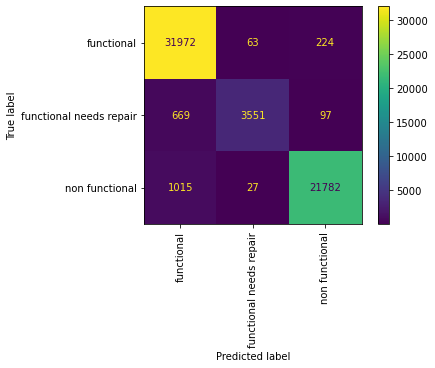

In [28]:
from sklearn.metrics import plot_confusion_matrix
plot_confusion_matrix(pipeline_OHE, X_train, y_train, values_format='.0f', xticks_rotation='vertical')